In [ ]:
! pip uninstall -y kaggle
! pip install --upgrade -q kaggle

Uninstalling kaggle-1.5.10:
  Successfully uninstalled kaggle-1.5.10
     |████████████████████████████████| 61kB 8.0MB/s 


In [ ]:
! mkdir -p /root/.kaggle
! cp kaggle.json /root/.kaggle/
import kaggle

In [ ]:
! kaggle competitions download -c dog-breed-identification

100% 690M/691M [00:17<00:00, 54.2MB/s]
100% 691M/691M [00:17<00:00, 41.8MB/s]


In [ ]:
! unzip -q dog-breed-identification.zip

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [ ]:
labels = pd.read_csv("labels.csv")

In [ ]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


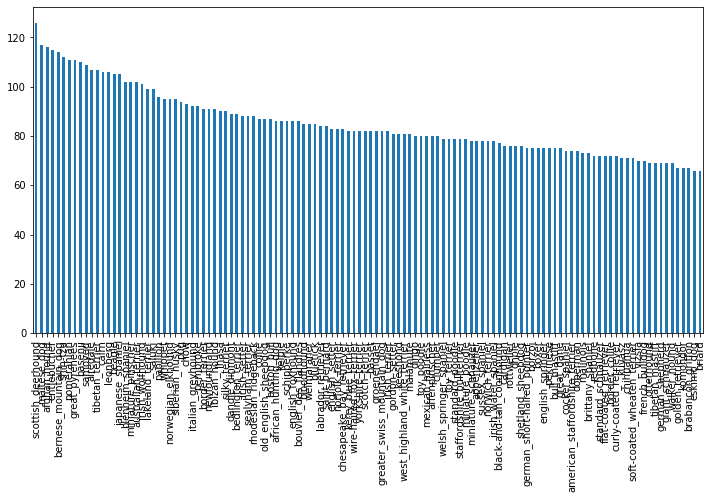

In [ ]:
plt.figure(figsize=(12, 6))
labels.breed.value_counts().plot.bar()

In [ ]:
labels["id"] = "train/" + labels["id"] + ".jpg"

In [ ]:
labels.head()

,id,breed
0,train/000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,train/001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,train/00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,train/0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16, inception_v3, xception, inception_resnet_v2

from tensorflow.keras.models     import Model, Sequential
from tensorflow.keras.layers     import Dense, Dropout, BatchNormalization, Lambda, Input, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import SGD, Adagrad
from tensorflow.keras.losses     import categorical_crossentropy
from tensorflow.keras.utils      import plot_model

In [14]:
[model for model in tf.keras.applications.__dir__() if model.startswith("__") == False and model[0].isupper()== True]

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet101',
 'ResNet152',
 'ResNet50',
 'ResNet101V2',
 'ResNet152V2',
 'ResNet50V2',
 'VGG16',
 'VGG19',
 'Xception']

In [ ]:
idg = ImageDataGenerator(validation_split=0.1, 
                         rotation_range=30, horizontal_flip=True)

In [ ]:
input_shape = (200, 200)
train_idg = idg.flow_from_dataframe(labels, x_col="id", y_col="breed", target_size=input_shape, batch_size=64, subset="training")
val_idg   = idg.flow_from_dataframe(labels, x_col="id", y_col="breed", target_size=input_shape, batch_size=64, subset="validation")

Found 9200 validated image filenames belonging to 120 classes.
Found 1022 validated image filenames belonging to 120 classes.


In [ ]:
# Functional Way of writing Model 
# out1 = Layer()(input)
# out2 = Layer()(out1)
# out3 = Layer()(out2)

In [ ]:
# vgg16.preprocess_input, xception.preprocess_input, inception_v3.preprocess_input

In [17]:
input_shape = (200, 200)
# Input Layer of Model
input = Input(shape=input_shape +  (3,))

# VGG 
vgg_data_pre = Lambda(vgg16.preprocess_input)(input)
vgg = vgg16.VGG16(input_shape=input_shape +  (3,), include_top=False)(vgg_data_pre)
vgg_avg = GlobalAveragePooling2D()(vgg)

# Resnet
resent_data_pre = Lambda(xception.preprocess_input)(input)
resnet = xception.Xception(input_shape=input_shape +  (3,), include_top=False)(resent_data_pre)
resnet_avg = GlobalAveragePooling2D()(resnet)

# Inception V3
inceptionv3_data_pre = Lambda(inception_v3.preprocess_input)(input)
inceptionv3 = inception_v3.InceptionV3(input_shape=input_shape +  (3,), include_top=False)(inceptionv3_data_pre)
inceptionv3_avg = GlobalAveragePooling2D()(inceptionv3)

add = Concatenate()([vgg_avg, resnet_avg, inceptionv3_avg])

droput = Dropout(0.7)(add)
dense = Dense(120, activation="softmax")(droput)
final_model = Model(inputs=[input], outputs=[dense])


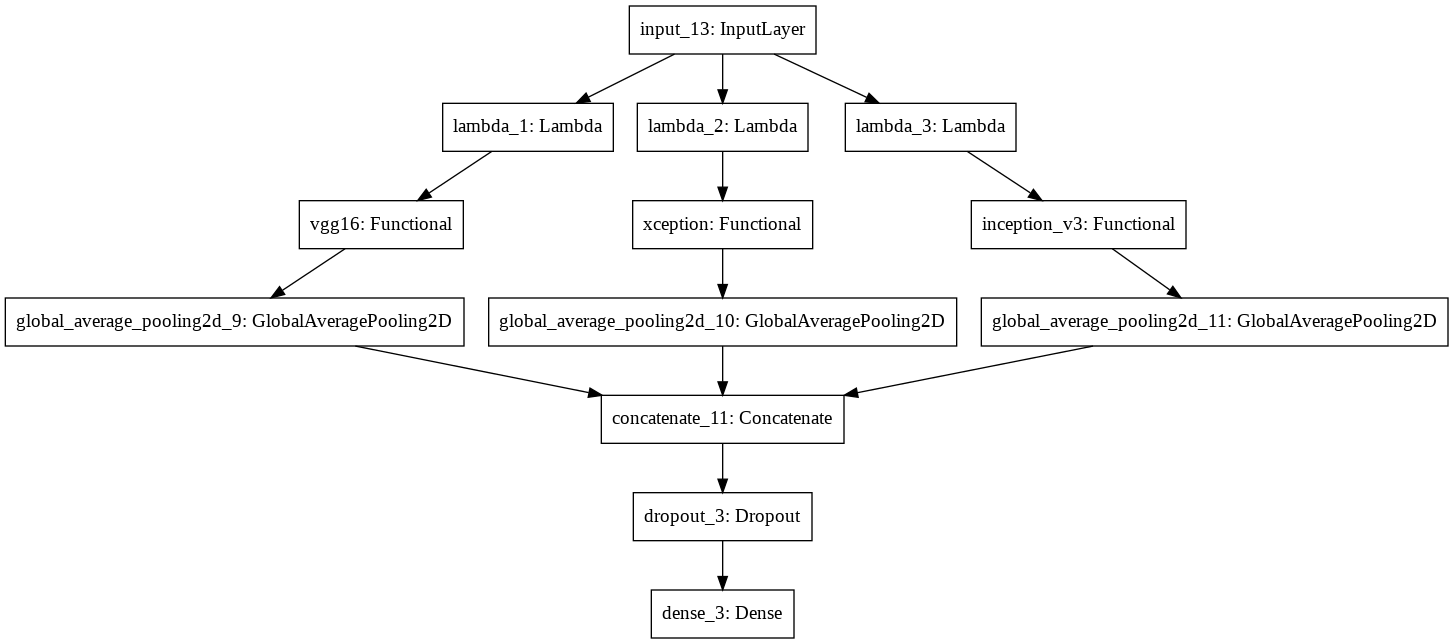

In [18]:
plot_model(final_model)

In [8]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 6, 6, 512)    14714688    input_5[0][0]                    
__________________________________________________________________________________________________
xception (Functional)           (None, 7, 7, 2048)   20861480    input_5[0][0]                    
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 4, 4, 2048)   21802784    input_5[0][0]                    
____________________________________________________________________________________________

In [ ]:
final_model.compile(optimizer="adam", loss=categorical_crossentropy, metrics=["acc"])

In [ ]:
final_model.fit(train_idg, validation_data=val_idg, epochs=20)